In [1]:
from sqlalchemy import create_engine
import pandas as pd

from paths import HERE

DB_PATH = HERE.joinpath('experiment_results.db').as_posix()
conn = create_engine(f'sqlite:///{DB_PATH}')


In [2]:
query = """
select model_scores,
       group_key,
       couple_tpr,
       couple_fpr,
       group_size,
       nb_attributes,
       nb_groups,
       granularity,
       intersectionality,
       similarity,
       1 - alea_uncertainty                                             as alea_uncertainty,
       1 - epis_uncertainty                                             as epis_uncertainty,
       magnitude,
       frequency,
       count(CASE WHEN diff_outcome_y IS NOT NULL THEN 1 ELSE NULL END) as count_non_null_diff_outcome_y
from results2
group by model_scores,
         group_key
order by count_non_null_diff_outcome_y DESC;
"""

df = pd.read_sql_query(query, conn)
df

,model_scores,group_key,couple_tpr,couple_fpr,group_size,nb_attributes,nb_groups,granularity,intersectionality,similarity,alea_uncertainty,epis_uncertainty,magnitude,frequency,count_non_null_diff_outcome_y
0,"[{'model': 'MLPClassifier', 'score': 0.5408525...",0|0|0*1|0|0,0.250000,1.000000,17.0,3.0,257.0,2.0,1.0,0.583716,0.019875,0.029712,0.802761,0.664750,834
1,"[{'model': 'MLPClassifier', 'score': 0.5408525...",1|0|0*0|0|0,0.250000,1.000000,7.0,3.0,257.0,2.0,1.0,0.595895,0.009628,0.029578,0.803265,0.194799,618
2,"[{'model': 'RandomForestClassifier', 'score': ...",2|2|0*2|2|4,0.033362,0.464286,28.0,3.0,423.0,2.0,1.0,0.282086,0.150024,0.318908,0.394108,0.901670,460
3,"[{'model': 'RandomForestClassifier', 'score': ...",0|0|0*2|0|0,0.083333,1.000000,16.0,3.0,498.0,2.0,1.0,0.286194,0.128036,0.493028,0.166367,0.567782,432
4,"[{'model': 'DecisionTreeClassifier', 'score': ...",2|0|0|-1*2|0|3|-1,0.121547,0.916667,19.0,4.0,306.0,2.0,1.0,0.577481,0.186741,0.108279,0.716784,0.641147,420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48999,"[{'model': 'SVC', 'score': 0.8144104803493449,...",3|3|2|2|2|2*3|2|1|0|3|3,0.000000,0.000000,27.0,6.0,585.0,4.0,2.0,0.755692,0.165602,0.438338,0.844869,0.909542,0
49000,"[{'model': 'SVC', 'score': 0.8144104803493449,...",3|3|2|2|3|2*3|3|2|0|2|3,0.000000,0.000000,28.0,6.0,585.0,4.0,2.0,0.259681,0.172895,0.419017,0.828658,0.915938,0
49001,"[{'model': 'SVC', 'score': 0.8144104803493449,...",3|3|3|-1|0|2*2|2|0|-1|0|1,0.000000,0.000000,27.0,6.0,585.0,3.0,2.0,0.729336,0.152955,0.148949,0.864680,0.893619,0
49002,"[{'model': 'SVC', 'score': 0.8144104803493449,...",3|3|3|2|2|2*2|1|1|1|1|0,0.000000,0.000000,27.0,6.0,585.0,4.0,2.0,0.952396,0.139716,0.484174,0.864340,0.891258,0


In [3]:
import json
df['model_type'] = df['model_scores'].apply(lambda x:json.loads(x.replace("\'", "\""))[0]['model'] if isinstance(x, str) else x)
df['mod_score'] = df['model_scores'].apply(lambda x:json.loads(x.replace("\'", "\""))[0]['f1_score'] if isinstance(x, str) else x)


In [4]:
# Assuming df is predefined and already imported
dff = df[df['count_non_null_diff_outcome_y']>50]


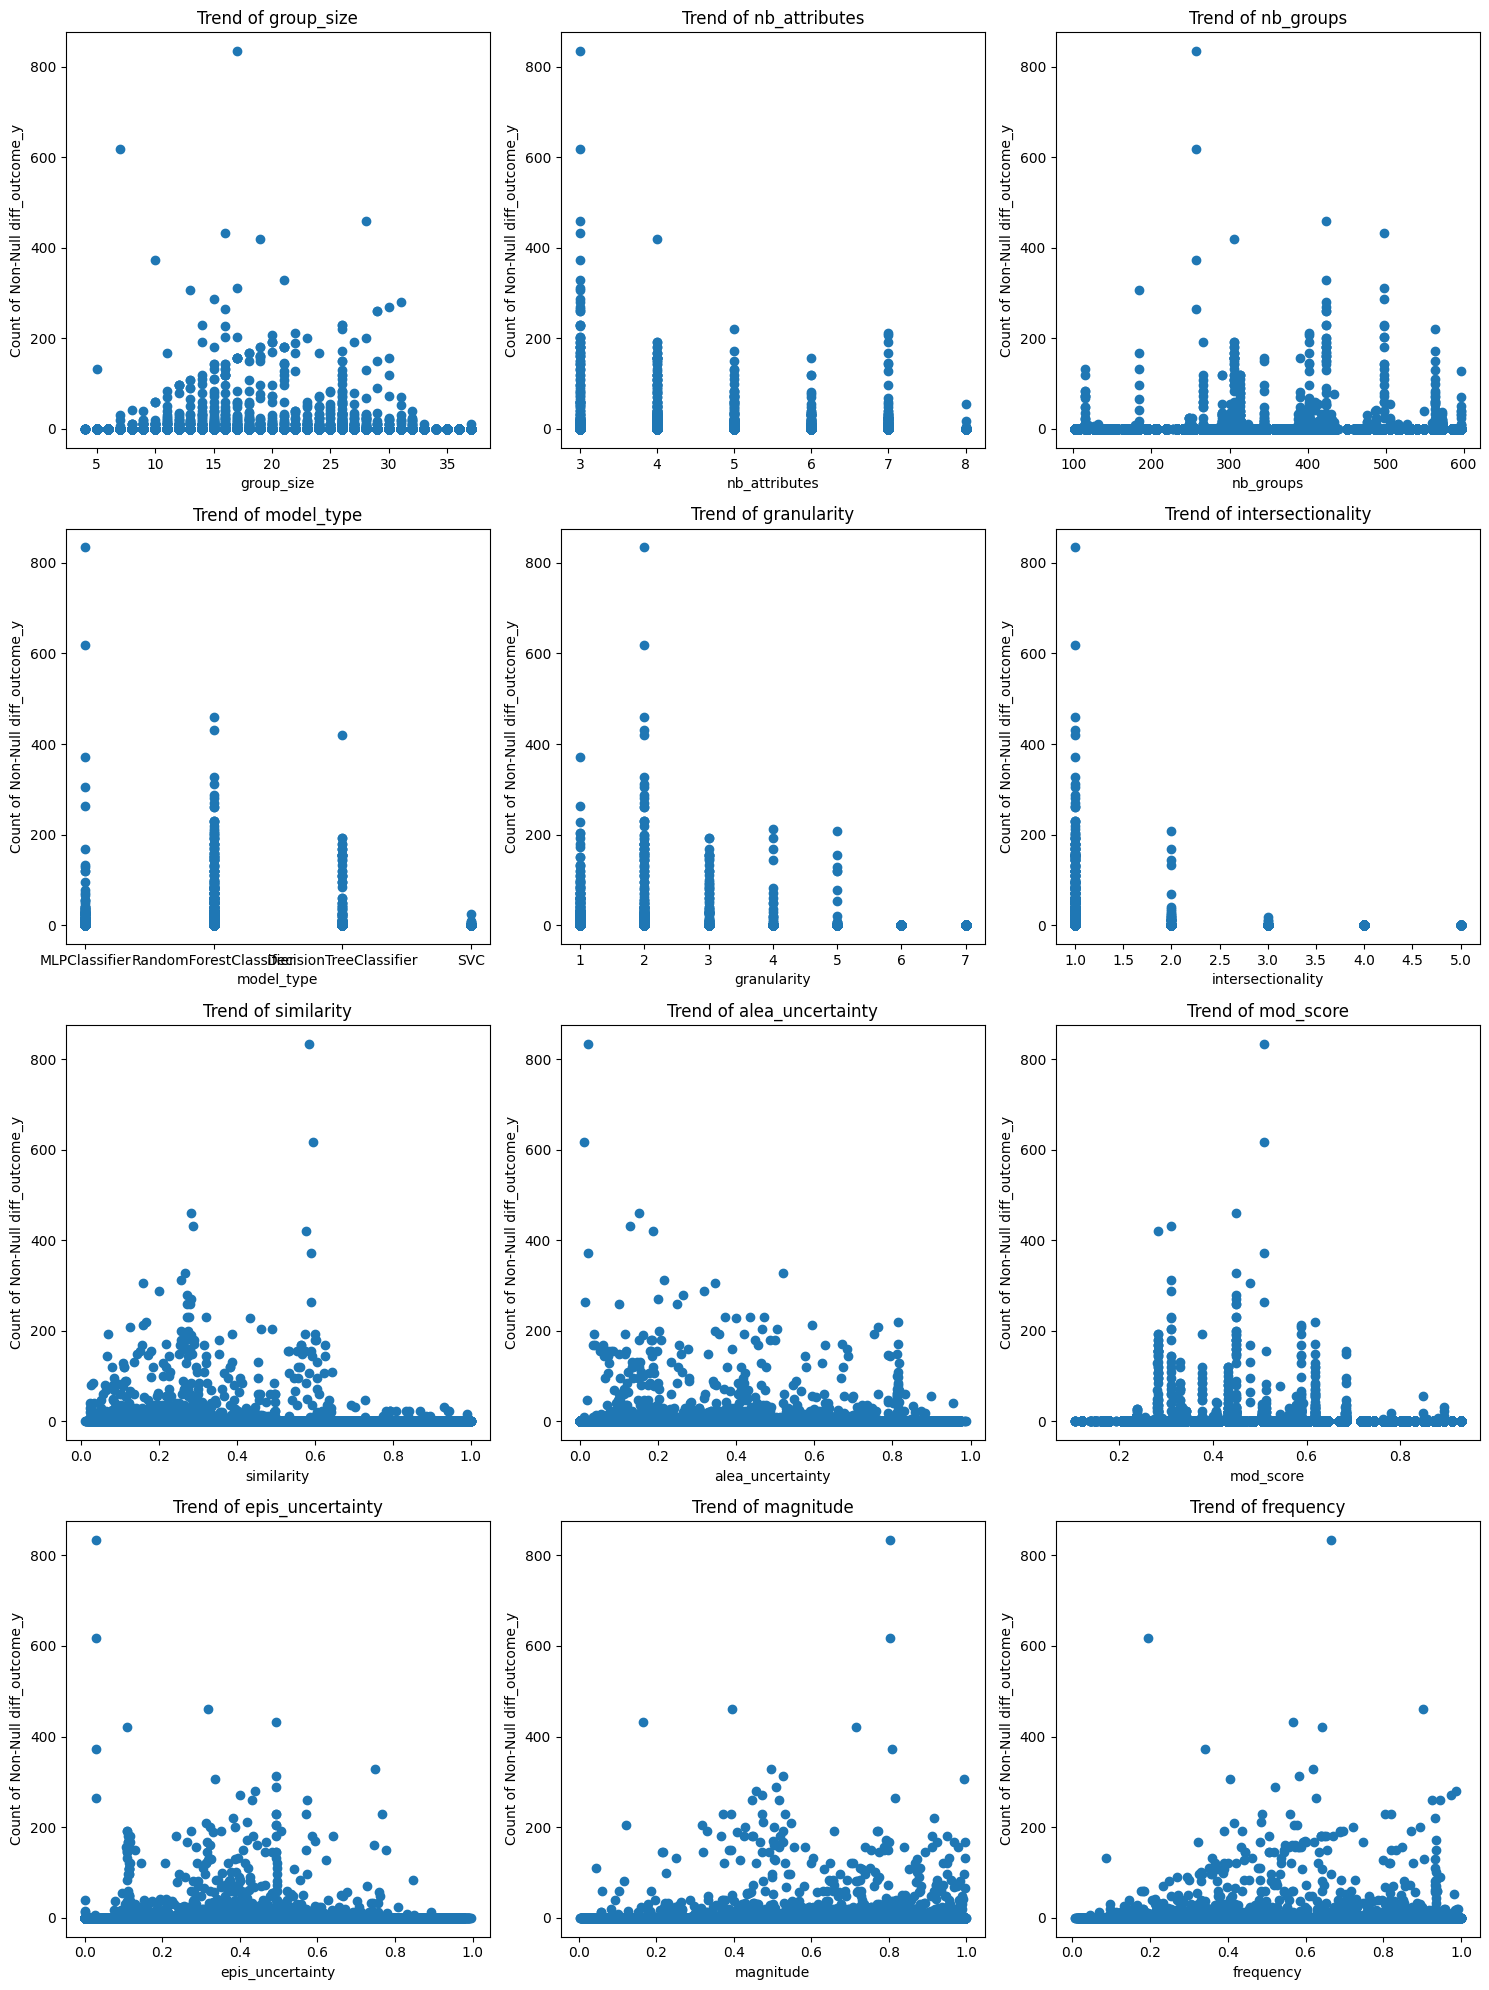

In [6]:

import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))
axes = axes.flatten()
properties = [
    'group_size', 'nb_attributes', 'nb_groups', 'model_type',
    'granularity', 'intersectionality', 'similarity', 'alea_uncertainty', 'mod_score',
    'epis_uncertainty', 'magnitude', 'frequency'
]

for i, prop in enumerate(properties):
    axes[i].scatter(df[prop], df['count_non_null_diff_outcome_y'])
    axes[i].set_title(f'Trend of {prop}')
    axes[i].set_xlabel(prop)
    axes[i].set_ylabel('Count of Non-Null diff_outcome_y')

plt.tight_layout()
plt.savefig('figuree1.png')
plt.show()

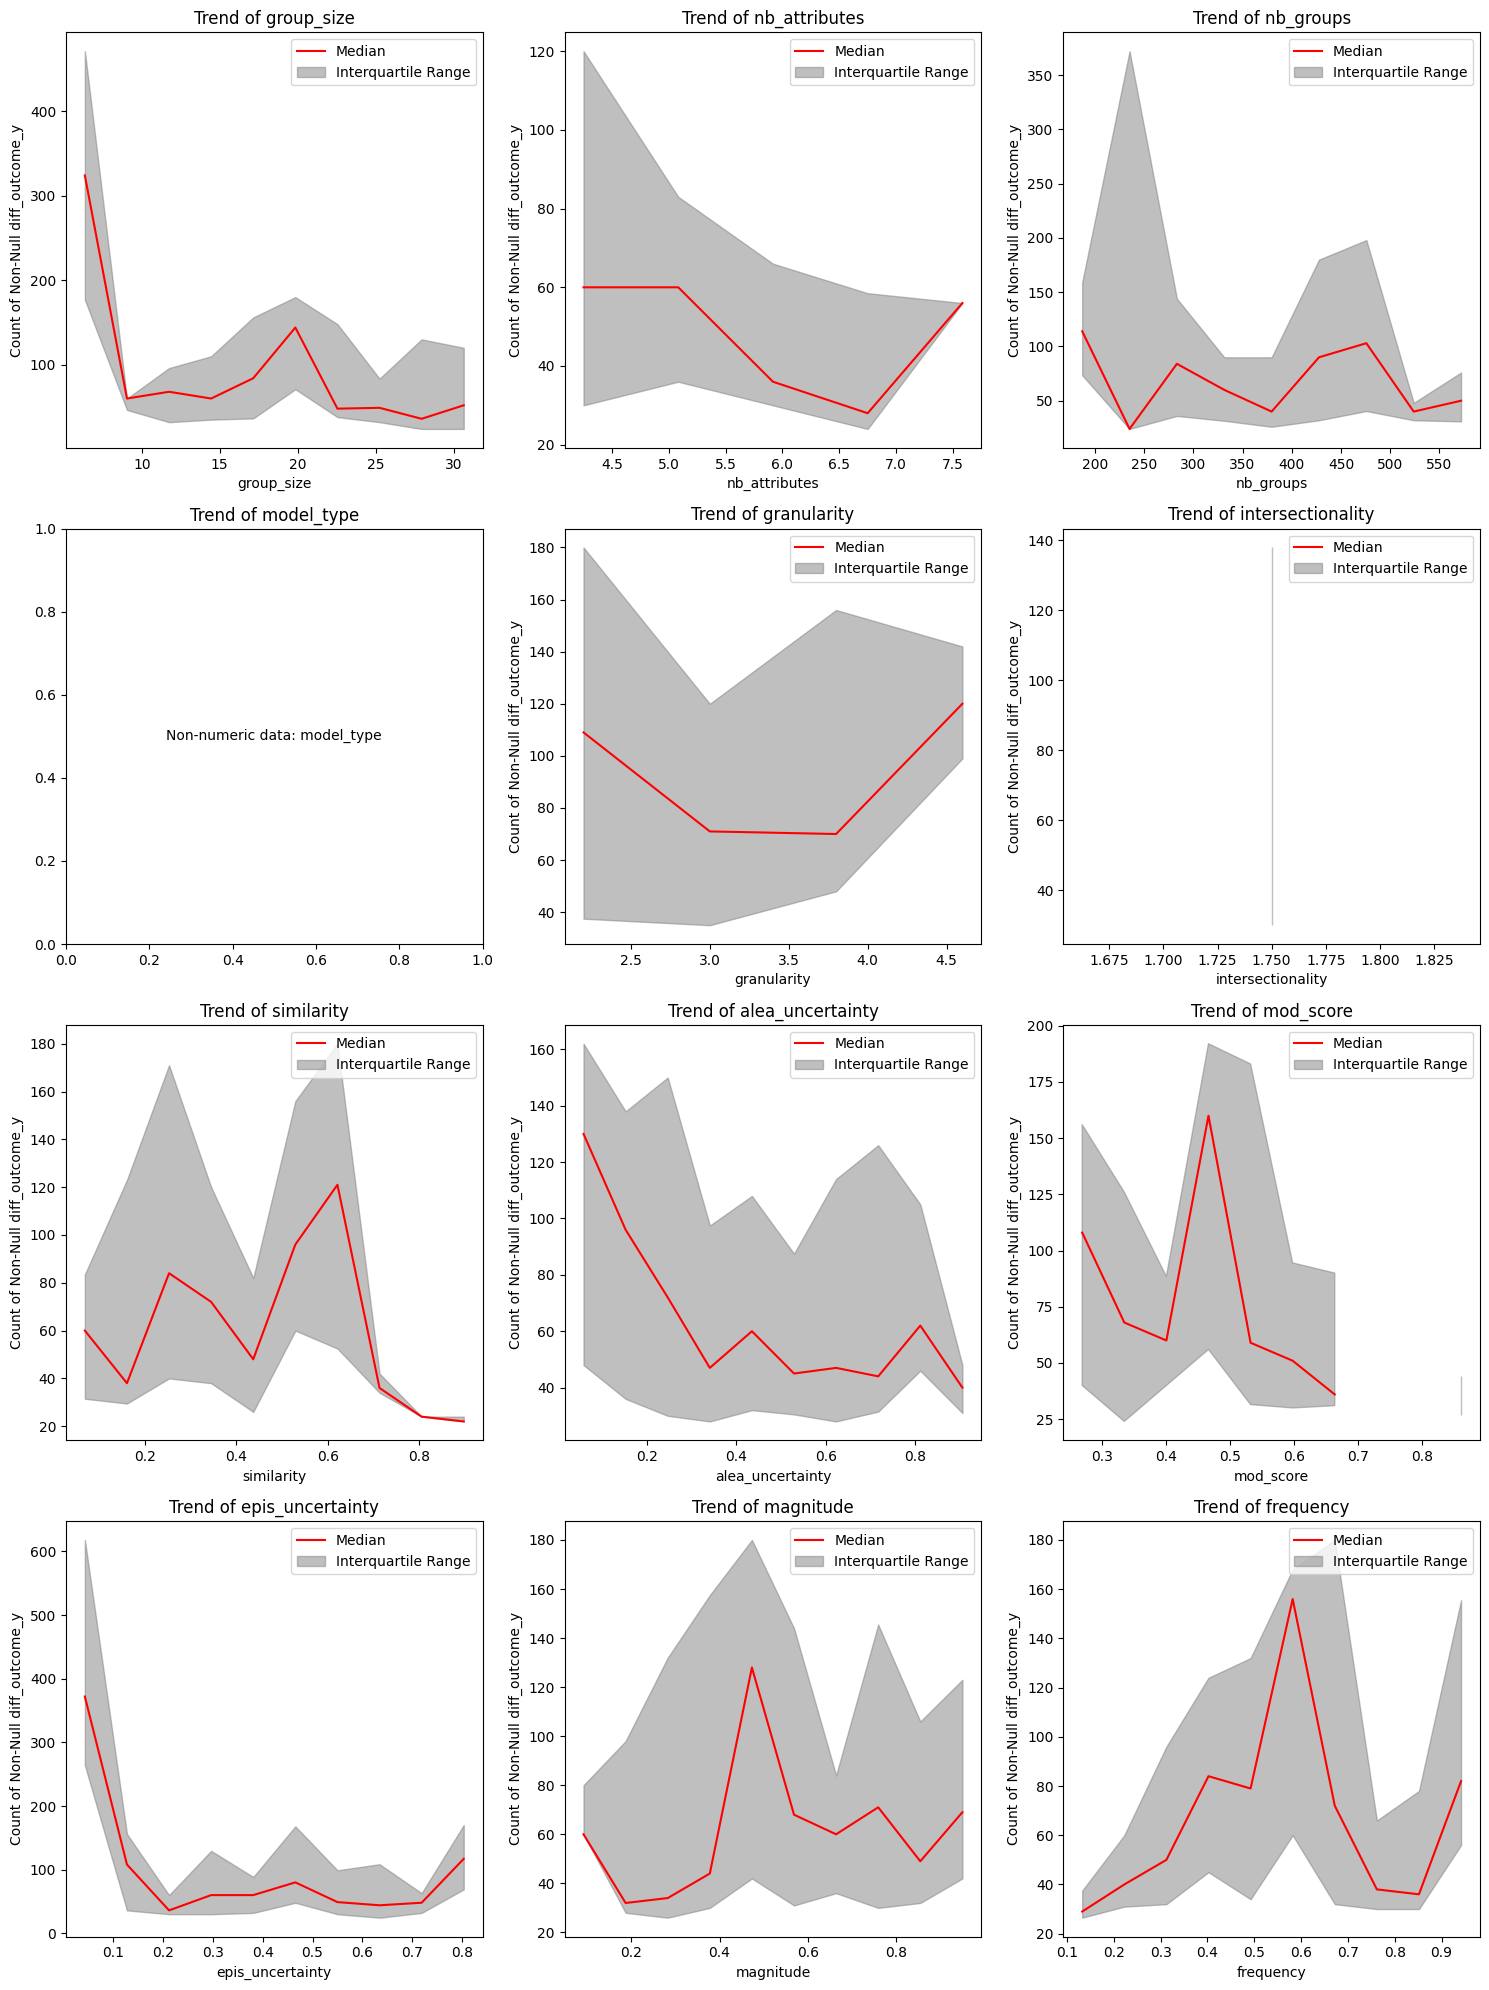

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is predefined and already imported
dff = df[df['count_non_null_diff_outcome_y']>20]

def bin_and_statistics(data, k):
    if data.shape[1] != 2:
        raise ValueError("Data must be a 2-dimensional array with shape (N, 2)")

    # Dynamically set k based on the unique values in the property
    unique_values = len(np.unique(data[:, 0]))
    k = min(k, unique_values)
    if k < 1:
        k = 1  # Ensure at least one bin

    min_val = np.min(data[:, 0])
    max_val = np.max(data[:, 0])
    
    bins = np.linspace(min_val, max_val, k + 1)
    bin_indices = np.digitize(data[:, 0], bins, right=True)
    
    # Statistics arrays
    medians = np.zeros(k)
    first_quartiles = np.zeros(k)
    third_quartiles = np.zeros(k)
    
    for i in range(1, k + 1):
        bin_elements = data[bin_indices == i, 1]
        
        if bin_elements.size > 0:
            medians[i - 1] = np.median(bin_elements)
            first_quartiles[i - 1] = np.percentile(bin_elements, 25)
            third_quartiles[i - 1] = np.percentile(bin_elements, 75)
        else:
            medians[i - 1] = np.nan  # Use NaN for empty bins
            first_quartiles[i - 1] = np.nan
            third_quartiles[i - 1] = np.nan

    return bins, medians, first_quartiles, third_quartiles

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))
axes = axes.flatten()

properties = [
    'group_size', 'nb_attributes', 'nb_groups', 'model_type',
    'granularity', 'intersectionality', 'similarity', 'alea_uncertainty', 'mod_score',
    'epis_uncertainty', 'magnitude', 'frequency'
]

for i, prop in enumerate(properties):
    if pd.api.types.is_numeric_dtype(dff[prop]):  # Check if the property is numeric
        data = dff[[prop, 'count_non_null_diff_outcome_y']].dropna().to_numpy()
        if data.size == 0:
            continue  # Skip if no data to plot
        bins, medians, first_quartiles, third_quartiles = bin_and_statistics(data, 10)
        bin_midpoints = (bins[:-1] + bins[1:]) / 2

        # Plotting median line
        axes[i].plot(bin_midpoints, medians, color='red', label='Median')
        # Plotting the uncertainty area between the first and third quartiles
        axes[i].fill_between(bin_midpoints, first_quartiles, third_quartiles, color='gray', alpha=0.5, label='Interquartile Range')

        axes[i].set_title(f'Trend of {prop}')
        axes[i].set_xlabel(prop)
        axes[i].set_ylabel('Count of Non-Null diff_outcome_y')
        axes[i].legend()
    else:
        axes[i].text(0.5, 0.5, f'Non-numeric data: {prop}', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
        axes[i].set_title(f'Trend of {prop}')

plt.tight_layout()
plt.savefig('figuree2.png')
plt.show()
